# supernode-edges

The procedure of constructing weighted L-space and P-space edges of the supernode network.

Requires:
1. `data/preprocessed/routes.json`
2. `data/supernodes/supernodes.json`

Produces:
1. `data/supernodes/edges_lspace.json`
2. `data/supernodes/edges_pspace.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import List
from collections import defaultdict

import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
from matplotlib import pyplot as plt

from myutils.networkx import get_layout
from myutils.spatial import get_earth_distances
from myutils.json import save_json

from config import routes_fpath, supernodes_fpath, edges_lspace_fpath, edges_pspace_fpath

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = 5, 5

In [3]:
routes = pd.read_json(routes_fpath).set_index('id')

routes.head(2)

,name,type,direction,stops,distance,supernodes
id,,,,,,
1125,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",5.008430,"[620, 827, 828, 20, 309, 80, 310, 204, 5, 29, ..."
11125,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",3.826103,"[30, 829, 830, 621, 311, 831, 14, 81, 620]"


In [4]:
supernodes = pd.read_json(supernodes_fpath).set_index('id')

supernodes.head(2)

,stops,diameter,types,lat,lon
id,,,,,
0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415
1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937


### L-space

In [5]:
edges = defaultdict(int)

for route in routes['supernodes']:
    for u, v in zip(route, route[1:]):
        if u > v:
            u, v = v, u
        
        edges[(u, v)] += 1
        
edges = [
    {
        'u': u,
        'v': v,
        'w': w,
    }
    for (u, v), w in edges.items()
]

edges[:5]

[{'u': 620, 'v': 827, 'w': 6},
 {'u': 827, 'v': 828, 'w': 10},
 {'u': 20, 'v': 828, 'w': 10},
 {'u': 20, 'v': 309, 'w': 12},
 {'u': 80, 'v': 309, 'w': 12}]

In [6]:
weighted_edges = [(edge['u'], edge['v'], edge['w']) for edge in edges]

g = nx.Graph()
g.add_weighted_edges_from(weighted_edges)

len(g), len(g.edges)

(3202, 5304)

In [7]:
# pos = get_layout(g)
pos = dict(zip(supernodes.index, supernodes[['lon', 'lat']].values))

In [8]:
components = list(nx.connected_components(g.to_undirected()))
color = {node: f'C{i}' for i, comp in enumerate(components) for node in comp}

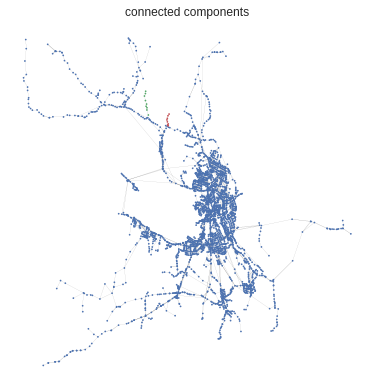

In [9]:
nx.draw(g.to_undirected(), pos, node_size=0.5, width=0.05, node_color=[color[node] for node in g])
plt.title('connected components');

In [10]:
save_json(edges, edges_lspace_fpath)

### P-space

In [11]:
coords = supernodes[['lat', 'lon']].values
distances = get_earth_distances(coords, coords)


def get_route_distance(route: List[int]) -> float:
    return distances[route[:-1], route[1:]].sum()

In [12]:
eps = 0.01

In [13]:
edges = []

for route_id, route in routes['supernodes'].iteritems():
    n = len(route)
    
    for i in range(n - 1):
        for j in range(i + 1, n):
            u = route[i]
            v = route[j]
            
            if u > v:
                u, v = v, u
            
            subroute = route[i : j + 1]
            distance = get_route_distance(subroute) + eps
            
            edges.append((u, v, distance, route_id))

edges = pd.DataFrame(edges, columns=['u', 'v', 'w', 'route'])\
    .sort_values(by=['u', 'v', 'w']).drop_duplicates(['u', 'v'], keep='first')

edges = [
    {
        'u': int(row['u']),
        'v': int(row['v']),
        'w': float(row['w']),
        'route': int(row['route'])
    }
    for _, row in edges.iterrows()
]

edges[:5]

[{'u': 0, 'v': 6, 'w': 23.28185292299166, 'route': 10003},
 {'u': 0, 'v': 8, 'w': 14.863275410682126, 'route': 2871},
 {'u': 0, 'v': 9, 'w': 13.995378725186596, 'route': 2871},
 {'u': 0, 'v': 13, 'w': 10.92823404394134, 'route': 1135},
 {'u': 0, 'v': 14, 'w': 12.609849731838038, 'route': 1085}]

In [14]:
weighted_edges = [(edge['u'], edge['v'], edge['w']) for edge in edges]

g = nx.Graph()
g.add_weighted_edges_from(weighted_edges)

len(g), len(g.edges)

(3202, 118449)

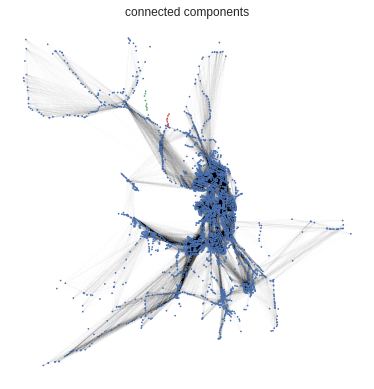

In [15]:
nx.draw(g.to_undirected(), pos, node_size=0.5, width=0.002, node_color=[color[node] for node in g])
plt.title('connected components');

In [16]:
save_json(edges, edges_pspace_fpath)